# "Tokenization for language modeling: Byte Pair Encoding vs Unigram Language Modeling"
> "Tokenizers used by the best-performing language models (Bert, GPT-2, etc.) poorly reflect the morphology of English text. I had hoped to use some quarantine time to design one that more closely aligns to relationships between wordforms. But Kaj Bostrom and Greg Durrett [beat me to it](https://arxiv.org/abs/2004.03720) and so this blog post materialized instead. I add some additional motivation, evaluate both methods against 'gold standard' tokenizations, and speculate about what might come next."

- toc: false
- branch: master
- badges: true
- comments: true
- categories: [tokenization, language models, byte pair encoding, unigram language model]
- image: images/tokenization-preview.png
- hide: false
- search_exclude: false
- permalink: tokenization

_My thanks to [Chris Potts](https://web.stanford.edu/~cgpotts/) and to [Eric Jeske](https://www.linkedin.com/in/ericjeske/) for valuable discussion of the ideas here and for their comments on early drafts of this post._

Imagine that you're learning English and you come across the word `destabilizing`. You've never seen it before, but you have seen `de-` as a prefix in lots of other words and know it's something to do with negating what follows, and you've seen `stabilizing` too. With that information, you can come to a more-or-less perfect understanding of `destabilizing`.

Now imagine that you mis-parsed the word and read it as `dest-abilizing`. Well, you've seen `dest` as the beginning of `destination`, `destiny` and `destroy`—perhaps `dest` is something to do with a future state? You've seen `ize` and `ing` suffixes, guess that `abilizing` means something like `enabling`, and conclude that `destabilizing` means something like _becoming able to do something_.

Unfortunately, common language tokenizers (including those used in Bert and GPT-2) misread words in just this way _all the time_:

In [1]:
#collapse-hide
from transformers import BertTokenizer, GPT2Tokenizer
from helpers.tokenization import *

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenize_funcs = [
    ('Bert', bert_tokenizer),
    ('GPT-2', gpt2_tokenizer),
]
FormattedTable(tokenize_funcs).print_table_from_words("stabilizing", "destabilizing")

            stabilizing       destabilizing   
  Bert     stab-ili-zing    des-ta-bil-izing  
 GPT-2     stabil-izing      destabil-izing   



There's no overlap between Bert's tokenizations of `stabilizing` and `destabilizing`: the model must learn about these words completely independently. GPT-2's tokenizer at least shares `izing` so the model has an indication that the words have something in common (albeit with `capsizing` too):

In [2]:
#collapse-hide
FormattedTable(tokenize_funcs).print_table_from_words("capsizing")

             capsizing     
  Bert      caps-izing     
 GPT-2      caps-izing     



Now consider `stigmatize` and `destigmatize`: not only is the significance of `de` missed, but both tokenizers give the model the misleading information that there is a relationship between `destigmatize` and `destinies`, even though the `de` is operating as a negator in the first, and part of the morpheme `des` in the second:

In [3]:
#collapse-hide
words = ['stigmatize', 'destigmatize', 'destinies']
FormattedTable(tokenize_funcs).print_table_from_words(*words)

             stigmatize        destigmatize        destinies     
  Bert    s-ti-gma-ti-ze    des-ti-gma-ti-ze      des-tin-ies    
 GPT-2      stigmat-ize      dest-igmat-ize       dest-in-ies    



A human reading `dest-igmat-ize` would have trouble understanding it until they recognized that the `st` belongs in the next group. Indeed, hyphenation dictionaries for e-readers disallow hyphens that break syllables for exactly this reason.

## Byte pair encoding (BPE)

The tokenizer used by GPT-2 (and most variants of Bert) is built using [_byte pair encoding_](https://leimao.github.io/blog/Byte-Pair-Encoding/) (BPE). Bert itself uses some proprietary heuristics to learn its vocabulary but uses the same greedy algorithm as BPE to tokenize. BPE comes from information theory: the objective is to maximally compress a dataset by replacing common substrings with tokens, morphology be damned. 

Are we disadvantaging language models by partitioning words in ways that obscure the relationships between them? Perhaps this doesn't matter. Traditional NLP models used whole words as tokens which by definition have to be learned independently, so we're better off than we used to be! Bert and GPT-2 are able to achieve astounding results with these 'misleading' tokens. The models are large enough that (presumably) the `dest` subword representation gets a little bit of `de-` plus a little bit of `destiny/destroy/destination/etc`, and they train on so much data that they see variants of `stabilize` often enough to learn the same aspects of 'meaning' redundantly.

On the other hand, the job of machine learning algorithms is to find and learn regularities in the training data. Providing them with the tokens that best capture these regularities (such as prefixes and suffixes) seems likely to help. Perhaps such a model could be smaller or could train more quickly.

Oddly, though, BPE has been more-or-less universally accepted as the standard preprocessing step for language modelling. Even Google's [T5 paper](https://arxiv.org/abs/1910.10683) which, in 30 meticulous pages, adjusted and evaluated every hyperparameter imaginable⁠, treated the tokenizer as fixed. The [RoBERTa paper](https://arxiv.org/abs/1907.11692) does consider tokenization in the _Text Encoding_ section, but only compares variants of BPE (Bert's tokenizer and vanilla BPE).

## Unigram language modeling

[Recent work by Kaj Bostrom and Greg Durrett](https://arxiv.org/abs/2004.03720) showed that by simply replacing BPE with a different method, morphology is better preserved and a language model trained on the resulting tokens shows improvements when fine tuned on downstream tasks.

Surprisingly, the replacement—unigram language modeling—has been under our noses all along. (Don't be confused with the _language model_ in the name: this is still the preprocessing step.) Unigram LM tokenizers are already implemented in Google's [sentencepiece library](https://github.com/google/sentencepiece), but it was introduced in [a paper ostensibly about data augmentation for translation models](https://arxiv.org/abs/1804.10959) and so the wider significance seems to have been missed.

Bostrom and Durrett's paper show some examples illustrating the difference:

<img src="images/tokenization/bostrom_examples.png" width="500" />

They explain that unigram LMs recover common suffixes like 'ly', 's' and 'ing' much more often than BPE. This is exactly what we wanted! I trained my own unigram LM and BPE tokenizers on 10 million randomly-selected sentences from Wikipedia to see if I could replicate these differences and to compare how they treat my `destabilizing` example. Here are the results with vocabularies limited to 8k and 32k words:

In [5]:
#collapse-hide
my_tokenizers = [
    ('BPE 8k', load_tokenizer('bpe', 8)),
    ('BPE 32k', load_tokenizer('bpe', 32)),
    ('Unigram LM 8k', load_tokenizer('ulm', 8)),
    ('Unigram LM 32k', load_tokenizer('ulm', 32)),
]
FormattedTable(my_tokenizers).print_table_from_words("stabilizing", "destabilizing")

                     stabilizing       destabilizing   
         BPE 8k    st-ab-il-izing    dest-ab-il-izing  
        BPE 32k     stabil-izing      dest-abil-izing  
  Unigram LM 8k     sta-bil-izing    de-sta-bil-izing  
 Unigram LM 32k     stabiliz-ing      de-stabiliz-ing  



This seems to have worked well! Both Unigram LM tokenizers treat `destabilizing` as `de+stabilizing`, but BPE doesn't. (It's not quite this simple: I've hidden the fact that the first token in a word is necessarily distinct from any subsequent token to keep track of word boundaries; more on that later.)

## Evaluating tokenizers

Bostrom and Durrett's paper includes comparisons of the length distribution of tokens and the frequency with which they are used, but that doesn't reflect how a tokenizer captures morphology. To do that, we need gold standard tokenizations: the ones that best capture pronunciation while preserving spelling. Luckily, that's exactly what Merriam Webster provides, at least for headwords (i.e. the base form of a word from which others derive: `stabilize` is the headword of `stabilizing`). For example, here's its entry for `destabilize` with the pronunciation guide highlighted:

<img src="images/tokenization/mw_destabilize.png" width="350" />

I'll call a subword _morphologically sound_ if it consists of one or more entire Merriam Webster subwords. For example, `de`, `lize`, `stabilize` and `destabilize` are all morphologically sound, but `dest` isn't. We can't expect a tokenizer to choose 'morphologically sound' subwords every time since that would require an enormous vocabulary; nevertheless, if tokenizer A produces more morphologically sound subwords than tokenizer B, it seems reasonable to conclude that tokenizer A better captures morphology than B. The table below shows a few examples color-coded to indicate which subwords are morphologically sound:

In [6]:
#collapse-hide
tokenizers = [
    ('BPE 32k', load_tokenizer('bpe', 32)),
    ('Unigram LM 32k', load_tokenizer('ulm', 32)),
    ('Bert', bert_tokenizer),
    ('GPT-2', gpt2_tokenizer),
]
examples_to_display = [
    ["spac", "ing"],
    ["pen", "chant"],
    ["brachy", "ther", "a", "py"],
    ["in", "ter", "mo", "lec", "u", "lar"],
    ["blurt"],
    ["whit", "en"],
    ["nod", "u", "lar"],
    ['daunt', 'ing'],
]
FormattedTable(tokenizers).print_table_from_gold_standard(*examples_to_display)

                       spacing            penchant     
  Gold standard       spac-ing           pen-chant     
        BPE 32k       sp-acing           pen-chant     
 Unigram LM 32k        spacing           pen-chant     
           Bert       spa-cing          pen-chan-t     
          GPT-2        spacing           penchant      

                    brachytherapy      intermolecular  
  Gold standard   brachy-ther-a-py  in-ter-mo-lec-u-lar
        BPE 32k   bra-chy-the-rapy   inter-m-ole-cular 
 Unigram LM 32k    bra-chy-therapy    inter-molecular  
           Bert   bra-chy-ther-ap-y  inter-mo-le-cular 
          GPT-2   br-achy-ther-apy   inter-m-ole-cular 

                        blurt              whiten      
  Gold standard         blurt             whit-en      
        BPE 32k        bl-urt             whit-en      
 Unigram LM 32k        blur-t             white-n      
           Bert        blur-t             white-n      
          GPT-2        bl-urt             whit

I score how well each tokenizer does on this task with the fraction of the subwords produced by a tokenizer that are morphologically sound (i.e. green). Bert gets a score of 6/22 = 27% for the sample above because 6 of its 22 subwords are green (`pen`, `ther`, `inter`, `mo`, `nod`, and `ular`), while GPT-2 gets 10/17 = 59% because 10 of its 17 subwords are green (including whole-word subwords like `spacing` and `penchant`).

We can't draw conclusions from this tiny sample, so I repeated the evaluation with a much larger sample of 8,000 words. Since having access to more subwords allows a tokenizer to make fewer splits and thus provides an advantage, I built tokenizers with different vocabulary sizes and plotted their scores against the vocabulary size (not counting tokens that include any non-ASCII characters to control for different numbers of characters represented).

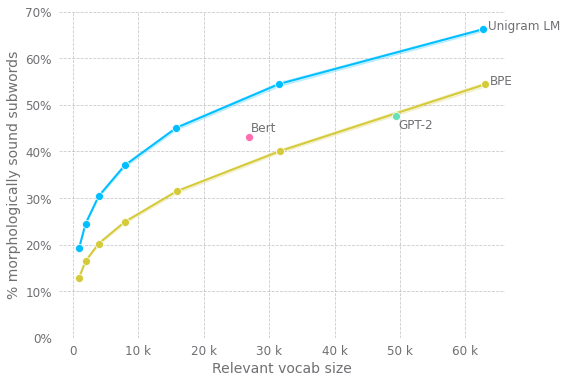

In [7]:
plot_tokenizer_evaluation_scores()

It's clear that Unigram LM-based tokenizers beat the BPE-based ones by a substantial margin. This supports Bostrom and Durrett's claim that "the  unigram LM method tends to produce more tokens that are morphologically interpretable."

## Speed

We might worry that this comes at the cost of slower performance. But we needn't be concerned: while _learning_ a Unigram LM tokenizer takes longer than BPE, it still took less than an hour for 10 million sentences on a 4-core, 32GB RAM EC2 machine (`r5ad.xlarge`):

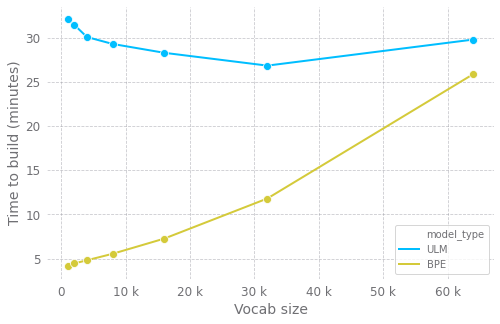

In [8]:
plot_learning_speed()

Interestingly, the Unigram LM gets faster to learn as the vocab size increases. That's because the algorithm starts with a larger set and prunes vocab items until the desired vocab size is reached, while BPE initializes with an empty vocabulary and adds tokens.

For _inference_, the difference is insignificant (the shaded area and vertical bars show 95% confidence intervals estimated by repeating the experiments 10 times):

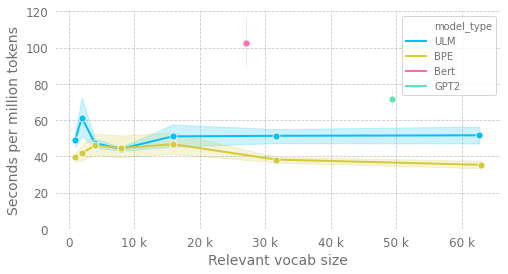

In [9]:
plot_inference_speed()

Bert and GPT-2's tokenizers are evaluated here using the `transformers` library which probably explains the slower performance compared to `sentencepiece`.

## What's next?

In the short term, I share Bostrom and Durret's hope "that developers of future pretrained language models will consider  adopting the unigram LM method over the more common BPE." But I suspect that there remain opportunities for further improvements.

First, as mentioned above, all tokenizers in common use treat subwords at the start of a word differently from those inside words. This is to permit unambiguous reconstruction of strings from token sequences (originally discussed in [Neural Machine Translation of Rare Words with Subword Units](https://arxiv.org/abs/1508.07909)). There may be other ways to achieve that aim without doubling the vocabulary, for instance by adding a <span style="font-variant:small-caps;">new_word</span> mask as an additional input dimension (which would be predicted by a seq-to-seq model as a secondary output).

Second, it's not clear to me using compression algorithms to preprocess inputs is a good idea at all. The renaissance of deep learning came after it was discovered that, with an appropriate architecture and sufficient compute, deep learning methods could learn better feature representations for images than humans could invent. That architecture—the convolutional neural network—embeds the nature of two-dimensional space and an invariance that objects can appear in different parts of an image.

The equivalent approach for natural language processing would have us treat raw characters (or bytes) as input. Character-level language modeling isn't novel: Andrej Karpathy's influential blog post [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) showed—in 2015—that character-level LSTMs could generate realistic text. Google's 2018 paper [Character-Level Language Modeling with Deeper Self-Attention](https://arxiv.org/abs/1808.04444) showed an impressive ability to memorize and reproduce random character sequences appearing in natural text, but it did it with sequences of at most 512 characters: less than two tweets, and much shorter than sequences used in the leading language models.

This length limitation comes from the attention mechanism used in transformers which scales quadratically in the length of the sequence. Replacing a token sequence with an equivalent character sequence would be computationally intractable. Linguists often represent text sequences as trees, and this might provide a clue as to how we can reduce computation while embedding more of language's structure in model architectures.

<img src="images/tokenization/parse_tree.jpg" width="400" />

_Example of a parse tree from [Wikipedia](https://en.wikipedia.org/wiki/Parse_tree)._

Attention can model these trees since every token can directly attend to any other, unlike RNNs which model distances linearly. That is, attention gives _ball_ a direct connection to _John_. But it's rare that a token should need to attend to another 500 tokens away, and so most of this computation is wasted. To best reflect a tree structure, we'd want attention to be applied to windowed subsequences at the bottom layers of a network and for those layers to produce a shorter representation that can be combined via attention with the outputs from neighboring windows. That would allow the bottom layer to operate on characters while remaining computationally tractable. I have vague ideas about how this might be realized, but I'm poorly-equipped to test them out! I'd love to hear about attempts to do anything like this, or about why it wouldn't work. You can tweet me [@ndingwall](https://twitter.com/nick_dingwall) or comment below.